In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
dropout = 0.5
epochs = 5
learning_rate = 0.001
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean = (0.5), std = (0.5))])

In [4]:
data_train = torchvision.datasets.MNIST(root = ".",
                            transform=transform,
                            train = True,
                            download = True)

len(data_train)

60000

In [5]:
data_test = torchvision.datasets.MNIST(root=".",
                           transform = transform,
                           train = False,
                           download = True)

len(data_test)

10000

In [6]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = batch_size,
                                                shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = batch_size,
                                               shuffle = True)


[6, 4, 5, 7, 0, 0, 0, 4, 0, 5, 3, 7, 6, 6, 7, 6, 0, 9, 1, 3, 7, 5, 4, 9, 8, 1, 9, 3, 8, 1, 8, 6, 3, 4, 8, 5, 4, 7, 4, 8, 1, 6, 4, 8, 3, 0, 9, 9, 6, 3, 1, 8, 0, 5, 3, 8, 4, 5, 0, 0, 7, 9, 6, 7]


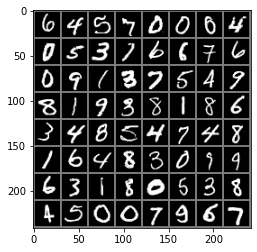

In [7]:
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1,2,0)
std = (0.5)
mean = (0.5)
img = img*std+mean
print([labels[i].item() for i in range(batch_size)])
plt.imshow(img)

In [8]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p=dropout),
                                         torch.nn.Linear(1024, 10))
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 14*14*128)
        x = self.dense(x)
        return x

In [9]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1,6,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU()
        )
 
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
 
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [10]:
#model = Model().to(device)
model = LeNet5().to(device)

In [11]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# model.load_state_dict(torch.load('model_parameter.pkl'))

In [12]:
for epoch in range(epochs):
    
    running_loss = 0.0
    running_correct = 0.0
    print("Epoch {}/{}".format(epoch+1, epochs))
    print("-"*10)
    for data in data_loader_train:
        x_train, y_train = data
        x_train, y_train = Variable(x_train).to(device), Variable(y_train).to(device)
        outputs = model(x_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
        running_correct += torch.sum(pred == y_train.data)
    
    testing_correct = 0.0
    for data in data_loader_test:
        x_test, y_test = data
        x_test, y_test = Variable(x_test).to(device), Variable(y_test).to(device)
        outputs = model(x_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is: {:.8f}, Train Accuracy is: {:.2f}%, Test Accuracy is: {:.2f}%\n".format(running_loss/len(data_train),
                                                                                            running_correct/len(data_train)*100,
                                                                                            testing_correct/len(data_test)*100))
# torch.save(model.state_dict(), "model_parameter.pkl")

Epoch 1/5
----------
Loss is: 0.00421097, Train Accuracy is: 91.81%, Test Accuracy is: 97.75%

Epoch 2/5
----------
Loss is: 0.00102613, Train Accuracy is: 97.96%, Test Accuracy is: 98.21%

Epoch 3/5
----------
Loss is: 0.00071862, Train Accuracy is: 98.58%, Test Accuracy is: 98.71%

Epoch 4/5
----------
Loss is: 0.00055415, Train Accuracy is: 98.90%, Test Accuracy is: 98.86%

Epoch 5/5
----------
Loss is: 0.00047393, Train Accuracy is: 99.05%, Test Accuracy is: 98.72%



Pred Label is: [0, 5, 9, 3, 8, 0, 0, 4, 2, 1, 2, 4, 7, 0, 0, 2, 1, 4, 1, 2, 9, 4, 3, 0, 6, 1, 3, 3, 1, 9, 8, 0, 0, 5, 4, 0, 7, 9, 5, 9, 6, 8, 5, 9, 4, 9, 2, 2, 3, 1]
Real Label is: [0, 5, 9, 3, 8, 0, 0, 4, 2, 1, 2, 4, 7, 0, 0, 2, 1, 4, 1, 2, 9, 4, 3, 0, 6, 1, 3, 3, 1, 9, 8, 0, 0, 9, 4, 0, 7, 9, 5, 9, 6, 8, 5, 9, 4, 9, 2, 2, 3, 1]


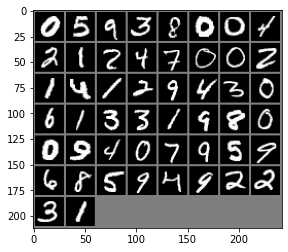

In [13]:
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size = 50,
                                          shuffle = True)
x_test, y_test = next(iter(data_loader_test))
inputs = Variable(x_test).to(device)
pred = model(inputs)
_,pred = torch.max(pred, 1)

print("Pred Label is:", [ i.item() for i in pred.data])
print("Real Label is:", [i.item() for i in y_test])

img = torchvision.utils.make_grid(x_test)
img = img.numpy().transpose(1,2,0)

std = (0.5)
mean = (0.5)
img = img*std+mean
plt.imshow(img)